## Predicting MISO Load from Hourly Temperature Observations using a Least-Squares Linear Model

In this notebook we perform the following steps:
* Obtain temperature observations from several weather stations in the MISO footprint
* Obtain the actual hourly MISO Load data
* Harmonize the hourly temperatures with the load data
* Predict the hourly load using a least-squares linear model

### Weather Data

Observation stations were chosen for geographical diversity and proximity to population centers.

In [1]:
from weather_data import get_station_df
from os.path import isfile
from datetime import *
from multiprocessing import cpu_count
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
from pathlib import Path

parallel = Parallel(n_jobs=cpu_count())

stations_dict = {'IA' : ['DSM', 'CID'],
                 'MN' : ['DLH', 'JKJ', 'LYV', 'MSP', 'RST'], 
                 'WI' : ['MSN', 'MKE', 'EAU', 'GRB'],
                 'MI' : ['ANJ', 'GRR', 'LAN', 'DET', 'ARB'],
                 'IN' : ['EVV', 'FWA', 'IND', 'SBN', 'SPI'],
                 'IL' : ['BMI', 'CMI', 'ARR', 'PIA'],
                 'MO' : ['STL', 'COU', 'SGF', 'MKC'],
                 'MS' : ['HKS', 'TUP', 'MEI'],
                 'LA' : ['BTR', 'LFT', 'LCH', 'SHV', 'AEX'],
                 'TX' : ['LFK'] }

stations = [(state, station) for state in stations_dict.keys() for station in stations_dict[state]]

def download_file_path(state, station):
    Path("./data/").mkdir(exist_ok=True)
    return f'./data/{state}_{station}.parquet'

def est(yyyy, mm, dd, hh):
    return datetime(yyyy, mm, dd, hh, tzinfo=timezone(timedelta(hours=-5)))

In [2]:
first_hour = est(2015,  2, 1,  0)
last_hour  = est(2021, 12, 31, 23)
observation_dates = pd.date_range(start = first_hour, end = last_hour)
observation_hours = [d.replace(hour = h) for d in observation_dates for h in range(0, 24)]

def download_station(state, station):
    path = download_file_path(state, station) 
    if isfile(path):
        return pd.read_parquet(path)

    station = get_station_df(station, first_hour, last_hour)
    if station is None:
        print(f'Retrieve {station} failed')
        return None
    return station.to_parquet(path)

_ = parallel(delayed(download_station)(state, station) for (state, station) in stations)

In [3]:
def build_hourly_df(state, station, observation_hours):
    w = pd.read_parquet(download_file_path(state, station))
    df = w[w['tmpf'] != 'M'].copy()
    df['valid'] = pd.to_datetime(df['valid'], utc = True)
    numeric_cols = ['tmpf', 'lat', 'lon']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, axis=1)
    df = df.drop(columns=['feel'])
    idx = df.drop_duplicates('valid').set_index('valid').index.get_indexer(observation_hours, method='nearest')
    df = df.iloc[idx]
    df.loc[: , 'valid'] = df['valid'].dt.round(freq='H')
    return df.drop_duplicates('valid') 

dfs = parallel(delayed(build_hourly_df)(state, station, observation_hours) for (state, station) in stations)
df = pd.concat(dfs, ignore_index=True)
df

,station,valid,tmpf,lat,lon
0,DSM,2015-02-01 05:00:00+00:00,33.98,41.5339,-93.6531
1,DSM,2015-02-01 06:00:00+00:00,33.08,41.5339,-93.6531
2,DSM,2015-02-01 07:00:00+00:00,33.08,41.5339,-93.6531
3,DSM,2015-02-01 08:00:00+00:00,33.08,41.5339,-93.6531
4,DSM,2015-02-01 09:00:00+00:00,33.08,41.5339,-93.6531
...,...,...,...,...,...
2275820,LFK,2021-12-31 19:00:00+00:00,78.10,31.2340,-94.7500
2275821,LFK,2021-12-31 20:00:00+00:00,81.00,31.2340,-94.7500
2275822,LFK,2021-12-31 21:00:00+00:00,81.00,31.2340,-94.7500
2275823,LFK,2021-12-31 22:00:00+00:00,81.00,31.2340,-94.7500


### Obtain the Regional MTLF and Actual Load for each Observation Hour

In [4]:
from rf_al_data import get_daily_rf_al_df

Path("./data/mtlf").mkdir(exist_ok=True)
forecast_output_dir = './data/mtlf'
# the actuals aren't available until the next day
actuals = get_daily_rf_al_df(first_hour, last_hour + timedelta(days=2.0), forecast_output_dir)
actuals

,Market Day,HourEnding,Central MTLF (MWh),Central ActualLoad (MWh),North MTLF (MWh),North ActualLoad (MWh),South MTLF (MWh),South ActualLoad (MWh),MISO MTLF (MWh),MISO ActualLoad (MWh)
1,2015-02-01,1,37796,36585.39,15885,16150.30,16067,16163.39,69748,68899.08
2,2015-02-01,2,36589,35509.04,15517,15713.40,15591,15571.34,67697,66793.78
3,2015-02-01,3,36067,34970.90,15187,15381.56,15272,15137.39,66526,65489.85
4,2015-02-01,4,35855,34708.83,15060,15239.59,15122,14935.61,66037,64884.03
5,2015-02-01,5,35835,34709.81,15027,15229.09,15080,14750.43,65942,64689.33
...,...,...,...,...,...,...,...,...,...,...
20,2021-12-31,20,37097,35527.32,20035,19940.40,20204,20083.71,77336,75551.43
21,2021-12-31,21,36329,34442.06,19699,19477.29,19658,19543.14,75686,73462.49
22,2021-12-31,22,35383,33472.41,19408,19040.22,19096,18934.14,73887,71446.77
23,2021-12-31,23,33996,32390.22,19038,18672.17,18403,18469.10,71437,69531.49


### Harmonize Features with Actuals

There are a number of lacunae in the weather observations.

In [5]:
def mktime_idx(row): 
    return datetime.combine(row['Market Day'].date(), time(row['HourEnding'] - 1), timezone(timedelta(hours = -5)))

actuals['time_idx'] = actuals.apply(mktime_idx, axis = 1)
p = df.pivot(index='valid', columns='station', values='tmpf').dropna()
data = p.join(actuals.set_index('time_idx'), how='inner')

(n, _) = data.shape
(num_weather_observations, _) = df.groupby('valid').count().shape
(num_load_observations, _) = actuals.shape
(num_weather_observations, num_load_observations, len(observation_hours), n)

(60610, 60624, 60624, 40639)

### Perform a Least-Squares Fit

In [10]:
import numpy as np

def fit_lstsq(features, data, intercept = None):
    features_df = data[features].copy()
    if(intercept):
        features_df[intercept] = np.ones(features_df.shape[0])
    y = data['MISO ActualLoad (MWh)']
    (A, [rss], _, _) = np.linalg.lstsq(features_df, y, rcond=None)
    return (A, features_df, rss)

station_temps = [s for l in stations_dict.values() for s in l]
(A, X, rss) = fit_lstsq(station_temps + ['HourEnding'], data, intercept='b')
miso_rss = np.sum(np.power(data['MISO ActualLoad (MWh)'] - data['MISO MTLF (MWh)'], 2))
f"Linear Model RSS = {rss:.1e} vs MTLF RSS = {miso_rss:.1e}"

'Linear Model RSS = 3.7e+12 vs MTLF RSS = 7.6e+10'

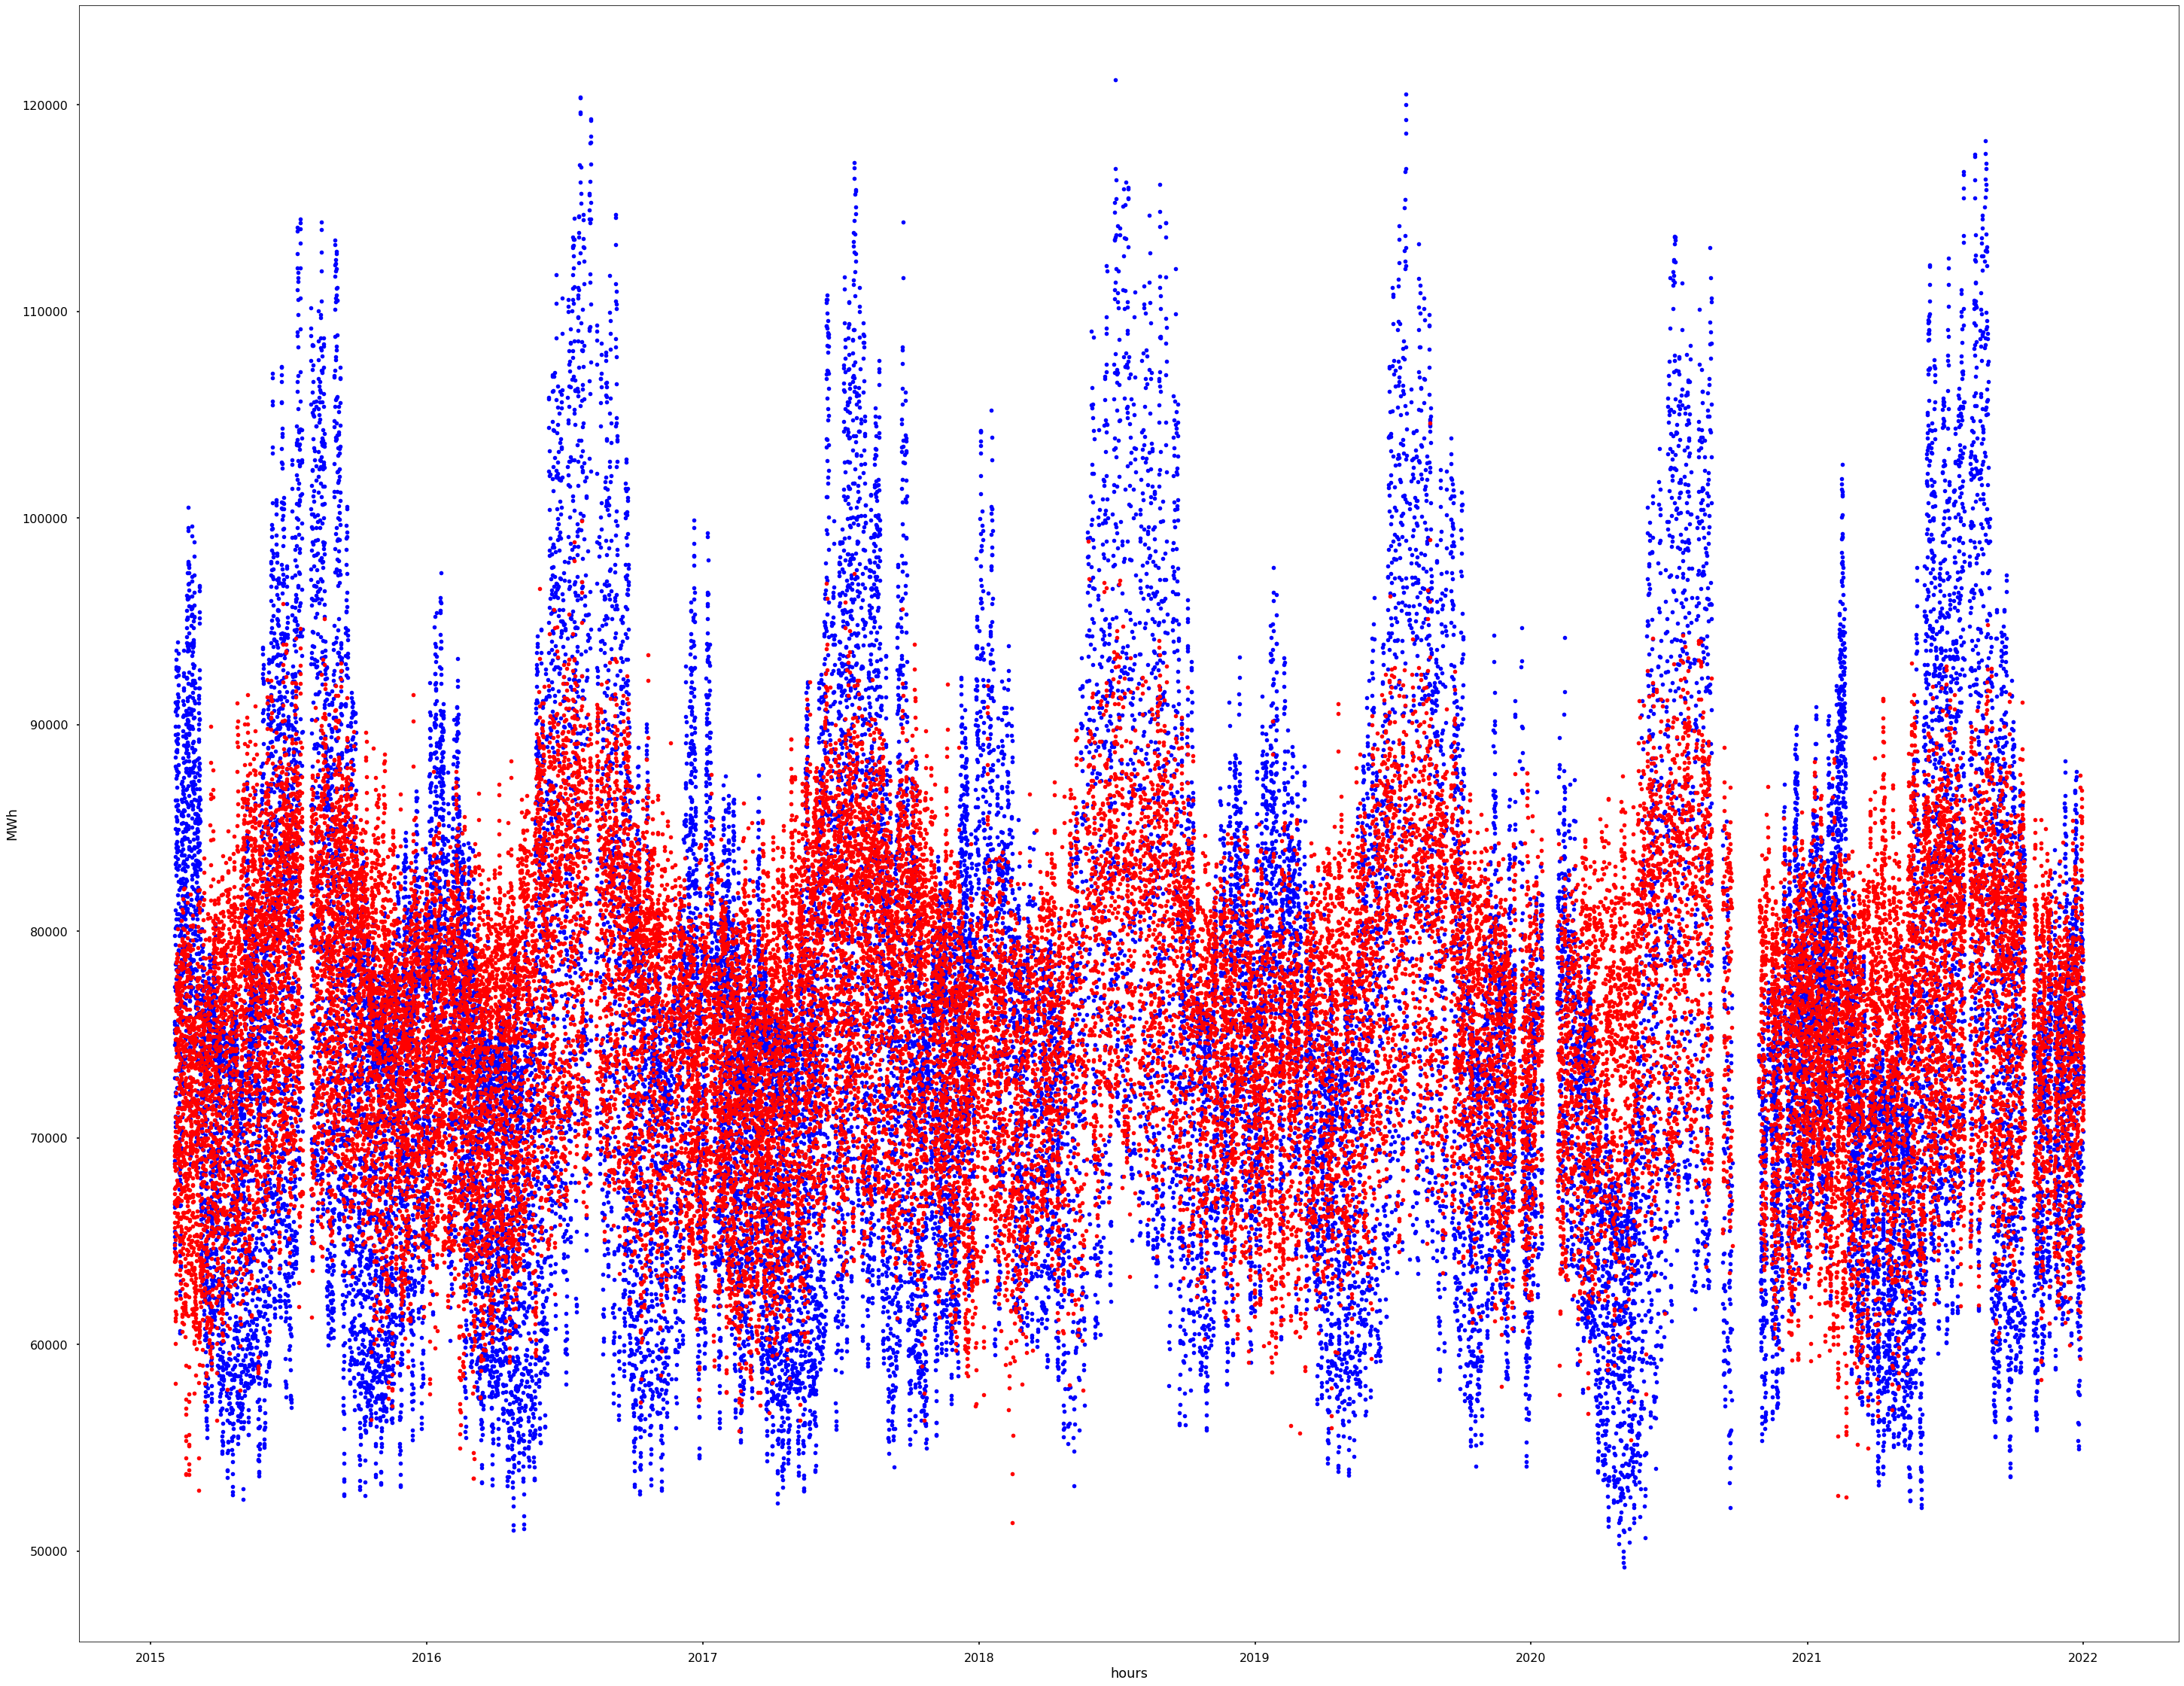

In [11]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-poster')

def plot_result(yhat, y, hours):
    plt.figure(figsize = (50, 40))
    plt.plot(hours, y, 'b.')
    plt.plot(hours, yhat, 'r.')
    plt.xlabel('hours')
    plt.ylabel('MWh')
    plt.show()

plot_result(np.inner(A, X), data['MISO ActualLoad (MWh)'], data.index)

This model seems to captures some of seasonality but also goes against the seasonal trend with regularity. Moreover it cannot obtain the extrema in most time perods.

## Feature Engineering: Business Hours

Can we improve the performance of the model by introducing business hours into the feature set?

In [12]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay, BusinessHour

federal_business_days = CustomBusinessDay(calendar=USFederalHolidayCalendar())
bh = BusinessHour()
def is_biz_hour(d):
    return federal_business_days.is_on_offset(d) and bh.is_on_offset(d)
data['IsBusinessHour'] = data.index.to_series().apply(lambda d: 1 if is_biz_hour(d) else 0)

In [13]:
(A, X, rss) = fit_lstsq(station_temps + ['HourEnding', 'IsBusinessHour'], data, intercept='b')
f"Linear Model RSS = {rss:.1e} vs MTLF RSS = {miso_rss:.1e}"

'Linear Model RSS = 3.5e+12 vs MTLF RSS = 7.6e+10'

This is a very slight improvement. This might have been anticipated from our plot, as the seasonal trend's inability to capture the extrema is the major source of loss.